# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Gian Marco Paldino - __[gian.marco.paldino@ulb.be](mailto:gian.marco.paldino@ulb.be)__
### Cédric Simar - __[cedric.simar@ulb.be](mailto:cedric.simar@ulb.be)__

## TP 2 - Linear Models

####  March 2025

In this session, we will:
1. Generate synthetic multivariate data.
2. **Manually compute** the Ordinary Least Squares (OLS) solution (matrix form).
3. Compare manual OLS results with `statsmodels` OLS.
4. Introduce **transformations** of inputs (e.g., polynomial, RBF expansions)
5. Explore **Ridge regression** (manual formula vs. scikit-learn).

We assume basic familiarity with matrix algebra and Python packages such as numpy, pandas, and statsmodels.



## 1. Generating Synthetic Multivariate Data

We'll create a dataset where `Y` depends on three features: `X1, X2, X3`.
The true data-generating process (DGP) is:

$$
  Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \epsilon,
$$
where $\epsilon \sim \mathcal{N}(0, \sigma^2)$.

### Steps
1. Create `N` observations of `(X1, X2, X3)`.
2. Define true coefficients `beta_true`.
3. Generate noise and produce `Y`.
4. Store everything in a DataFrame for convenience.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For stats and linear models
import statsmodels.api as sm
from scipy.stats import probplot

np.random.seed(123)

# Number of data points
N = 200
# True noise standard deviation
sigma_true = 2.0

# True coefficients (beta0, beta1, beta2, beta3)
beta_true = np.array([5.0, 1.5, -2.0, 0.5])

# Generate X1, X2, X3
X1 = np.random.uniform(-5, 5, size=N)
X2 = np.random.uniform(-10, 10, size=N)
X3 = np.random.normal(0, 2, size=N)

# Build DataFrame
df = pd.DataFrame({'X1':X1, 'X2':X2, 'X3':X3})

# Generate the true Y (without noise)
Y_true = (beta_true[0]
          + beta_true[1]*df['X1']
          + beta_true[2]*df['X2']
          + beta_true[3]*df['X3'])

# Add noise
noise = np.random.normal(0, sigma_true, size=N)
df['Y'] = Y_true + noise

df.head()


,X1,X2,X3,Y
0,1.964692,0.852719,-3.510804,5.687964
1,-2.138607,-8.664511,-0.697215,16.509223
2,-2.731485,3.067297,-0.385230,-4.050829
3,0.513148,9.921727,0.898271,-12.453060
4,2.194690,5.387947,-0.290727,-1.697682



### Quick Data Inspection

               X1          X2          X3           Y
count  200.000000  200.000000  200.000000  200.000000
mean     0.032708   -0.193044   -0.112239    5.572700
std      2.663947    5.907073    1.963533   12.473036
min     -4.973119   -9.929356   -5.262876  -20.342999
25%     -1.953937   -5.254828   -1.286318   -4.258475
50%      0.207716   -0.714124   -0.101728    5.417761
75%      2.181854    5.168943    1.206797   14.861563
max      4.953585    9.921727    4.501352   30.849943


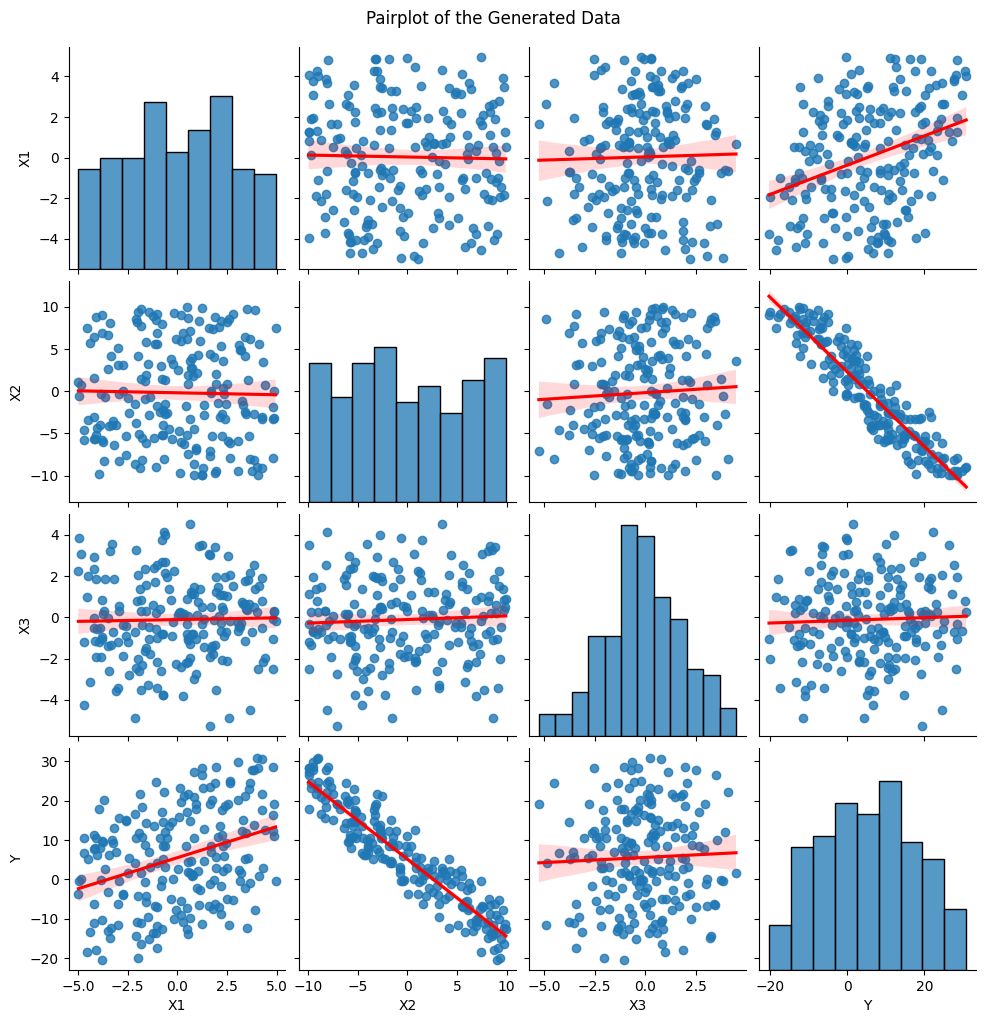

In [4]:
print(df.describe())

sns.pairplot(df, kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.suptitle("Pairplot of the Generated Data", y=1.02)
plt.show()



## 2. Manual OLS Computation (Matrix Form)

**Model**: 
$$
   \mathbf{Y} = X \boldsymbol{\beta} + \boldsymbol{\epsilon},
$$
where $X$ is an $N \times p$ matrix (including the column of ones for the intercept).

**Closed-form OLS**:
$$
   \hat{\boldsymbol{\beta}} = \bigl(X^\top X\bigr)^{-1} X^\top \mathbf{Y}.
$$

We'll:
1. Construct the design matrix manually.
2. Compute $\hat{\beta}$ using `np.linalg.inv(...)`.
3. Compare with the true coefficients `beta_true`.
4. Compare with `statsmodels` OLS results.

### 2.1 Build the design matrix


In [5]:
X_mat = np.column_stack([
    np.ones(N),    # intercept column
    df['X1'].values,
    df['X2'].values,
    df['X3'].values
])  # shape: (N, 4)

y_vec = df['Y'].values.reshape(-1,1)  # shape: (N,1)

print("X_mat shape:", X_mat.shape)
print("y_vec shape:", y_vec.shape)


X_mat shape: (200, 4)
y_vec shape: (200, 1)


In [6]:
XTX = X_mat.T @ X_mat           # (4,4) matrix
XTX_inv = np.linalg.inv(XTX)    # inverse (4,4)
XTy = X_mat.T @ y_vec           # (4,1)
beta_hat_manual = XTX_inv @ XTy # (4,1)

# Flatten for convenience
beta_hat_manual = beta_hat_manual.flatten()

print("Manual OLS estimates:", beta_hat_manual)
print("True coefficients:", beta_true)


Manual OLS estimates: [ 5.20431058  1.47721924 -1.96286883  0.52430039]
True coefficients: [ 5.   1.5 -2.   0.5]



We see the manually computed OLS estimates are close to the true ones.

### 2.3 Compare with statsmodels

We'll let `statsmodels` compute OLS, then compare the results in detail.



In [7]:
X_design_sm = sm.add_constant(df[['X1','X2','X3']])  # same shape as X_mat
model_ols = sm.OLS(df['Y'], X_design_sm).fit()
print(model_ols.summary())

beta_hat_sm = model_ols.params.values
print("statsmodels OLS:", beta_hat_sm)
print("Manual OLS:", beta_hat_manual)


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2657.
Date:                Mon, 03 Feb 2025   Prob (F-statistic):          2.01e-158
Time:                        14:55:44   Log-Likelihood:                -415.03
No. Observations:                 200   AIC:                             838.1
Df Residuals:                     196   BIC:                             851.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2043      0.138     37.720      0.0


### Observations
- The "manual" results match `statsmodels` results (modulo tiny numerical differences).
- Both are near the true coefficients `(5.0, 1.5, -2.0, 0.5)`.

---

## 3. Residual Analysis and Tests

Once we have the fitted model, let's analyze **residuals**:
$$
  e_i = y_i - \hat{y}_i.
$$

In [ ]:
residuals = model_ols.resid
fitted_vals = model_ols.fittedvalues


When evaluating the quality of a regression model, it is crucial to check whether the underlying assumptions hold. Two common residual diagnostic plots are:

### **1. Residuals vs. Fitted Plot**
- **Purpose**: This plot helps detect **non-linearity** and **heteroscedasticity** (unequal variance of residuals).
- **How it works**:
  - The **x-axis** represents the fitted (predicted) values from the regression model.
  - The **y-axis** represents the residuals (errors).
  - Ideally, the residuals should be randomly scattered around zero, forming a **homogeneous "cloud"**.
- **Interpretation**:
  - If a clear pattern (e.g., a curve) appears, it suggests **non-linearity**, meaning the model might be missing key features or transformations.
  - If the spread of residuals **increases or decreases systematically**, it indicates **heteroscedasticity**, meaning the variance of errors is not constant, which violates regression assumptions.


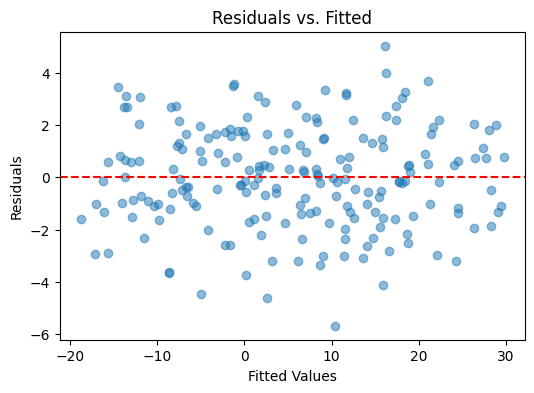

In [9]:


# Residual vs. Fitted
plt.figure(figsize=(6,4))
plt.scatter(fitted_vals, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.show()


### **2. Normal Q-Q Plot (Quantile-Quantile Plot)**
- **Purpose**: Checks whether the residuals follow a **normal distribution**, a key assumption in many regression analyses.
- **How it works**:
  - The **x-axis** shows the theoretical quantiles (expected values under normality).
  - The **y-axis** shows the actual quantiles from the residuals.
  - If the residuals are normally distributed, they should closely follow a **straight diagonal line**.
- **Interpretation**:
  - **Straight-line alignment**: Residuals are normally distributed.
  - **Deviations (e.g., S-shape, heavy tails, skewed distribution)**: Suggests non-normal residuals, which might indicate missing variables, skewed data, or influential outliers.

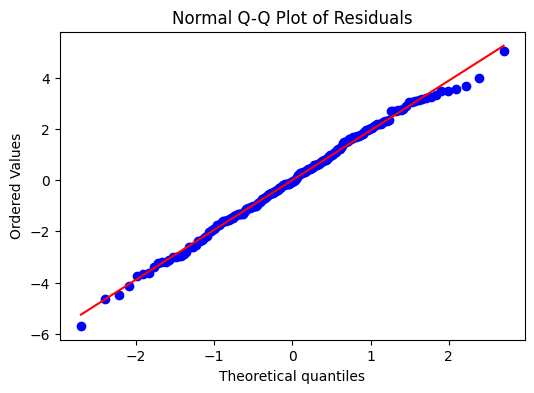

In [10]:
# Normal Q-Q
plt.figure(figsize=(6,4))
probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot of Residuals")
plt.show()


**Comments**:
- Ideally, residuals have **no clear pattern** vs. fitted values and appear "cloud-like."
- The Q-Q plot should be fairly linear if they are normally distributed.

We can also check the standard deviation or run further tests (e.g., Shapiro-Wilk, Breusch-Pagan for heteroscedasticity) if desired.

---

## 4. Input Transformations (Polynomial) + Manual OLS

When we talk about **linear regression**, we mean that the model is **linear in parameters**, not necessarily in the input variables $X$. That is, the target variable $y$ is modeled as a **linear combination of parameters**:

$$
y = \beta_0 + \beta_1 f_1(X) + \beta_2 f_2(X) + \dots + \beta_n f_n(X) + \epsilon
$$

where:
- $ \beta_0, \beta_1, \dots, \beta_n $ are the regression coefficients.
- $ f_i(X) $ are **functions of the input features** (which can be non-linear transformations like squares or interaction terms).
- $ \epsilon $ is the error term.

### **Example: Still a Linear Model**
Even if we introduce **non-linear transformations** of $X$, as long as the model is **linear in the parameters** $ \beta_i $, it is still considered a **linear model**. For example:

$$
y = \beta_0 + \beta_1 X + \beta_2 X^2 + \epsilon
$$

This model includes a quadratic term ($X^2$), but is still a **linear regression model** because it remains a linear combination of the parameters $\beta_0, \beta_1, \beta_2$.

### **What Would NOT Be a Linear Model?**
A regression model becomes **non-linear in parameters** if the parameters appear in a non-linear way. For example:

$$
y = \beta_0 + e^{\beta_1 X} + \epsilon
$$

or

$$
y = \frac{1}{\beta_0 + \beta_1 X} + \epsilon
$$

These models are **non-linear in parameters** because the relationship between $y$ and the $\beta$ coefficients is no longer a simple linear combination.

---

## **Why Use Polynomial Features in Linear Regression?**
Since linear regression allows us to use **non-linear transformations of $X$** while keeping the model linear in parameters, we can **extend linear regression** to capture more complex relationships.

### **Polynomial Feature Expansion**
Given original features $ X_1, X_2, X_3 $, we can introduce:
- **Squared terms**: $ X_1^2, X_2^2, X_3^2 $ → captures curvature.
- **Interaction terms**: $ X_1X_2, X_1X_3, X_2X_3 $ → captures relationships between variables.

By expanding the features in this way, we allow a linear regression model to **approximate non-linear patterns** in the data, making it more flexible while maintaining its interpretability.

### **Example**
A second-degree polynomial regression model:

$$
y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_1^2 + \beta_5 X_2^2 + \beta_6 X_3^2 + \beta_7 X_1X_2 + \beta_8 X_1X_3 + \beta_9 X_2X_3 + \epsilon
$$

This is still **a linear model in parameters** but now captures non-linear relationships in $X$.

---

### **How to Implement Polynomial Features in Python**
In Python, we can generate polynomial features using `sklearn.preprocessing.PolynomialFeatures`

In [12]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df[['X1','X2','X3']])
print("Original shape:", df[['X1','X2','X3']].shape)
print("Polynomial shape:", X_poly.shape)

# Build a new design matrix with intercept for manual OLS:
X_poly_mat = np.column_stack([np.ones(N), X_poly])  # shape: (N, num_features+1)


Original shape: (200, 3)
Polynomial shape: (200, 9)


In [13]:
# Manual OLS for polynomial design
XTX_poly = X_poly_mat.T @ X_poly_mat
XTX_poly_inv = np.linalg.inv(XTX_poly)
XTy_poly = X_poly_mat.T @ y_vec
beta_hat_poly_manual = XTX_poly_inv @ XTy_poly
beta_hat_poly_manual = beta_hat_poly_manual.flatten()

print("Manual OLS (polynomial) shape of beta:", beta_hat_poly_manual.shape)
print("beta_hat_poly_manual:", beta_hat_poly_manual[:10], "...")  # truncated for brevity


Manual OLS (polynomial) shape of beta: (10,)
beta_hat_poly_manual: [ 5.05257650e+00  1.47732427e+00 -1.96462434e+00  5.31472674e-01
  3.61323440e-03  5.35957501e-03  2.49420453e-02  3.66685538e-03
  1.32582661e-02 -2.64743927e-03] ...


In [14]:
# Compare with statsmodels:
X_poly_sm = sm.add_constant(X_poly)  # includes intercept
model_poly_sm = sm.OLS(df['Y'], X_poly_sm).fit()
beta_hat_poly_sm = model_poly_sm.params.values

print("Statsmodels polynomial OLS:", beta_hat_poly_sm[:10], "...")
print("Manual polynomial OLS:", beta_hat_poly_manual[:10], "...")
print("\nPolynomial OLS summary:\n", model_poly_sm.summary())


Statsmodels polynomial OLS: [ 5.05257650e+00  1.47732427e+00 -1.96462434e+00  5.31472674e-01
  3.61323440e-03  5.35957501e-03  2.49420453e-02  3.66685538e-03
  1.32582661e-02 -2.64743927e-03] ...
Manual polynomial OLS: [ 5.05257650e+00  1.47732427e+00 -1.96462434e+00  5.31472674e-01
  3.61323440e-03  5.35957501e-03  2.49420453e-02  3.66685538e-03
  1.32582661e-02 -2.64743927e-03] ...

Polynomial OLS summary:
                             OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     872.4
Date:                Mon, 03 Feb 2025   Prob (F-statistic):          2.13e-149
Time:                        15:05:19   Log-Likelihood:                -413.46
No. Observations:                 200   AIC:                             846.9
Df Residuals:                     


### Residual Analysis (Polynomial Model)


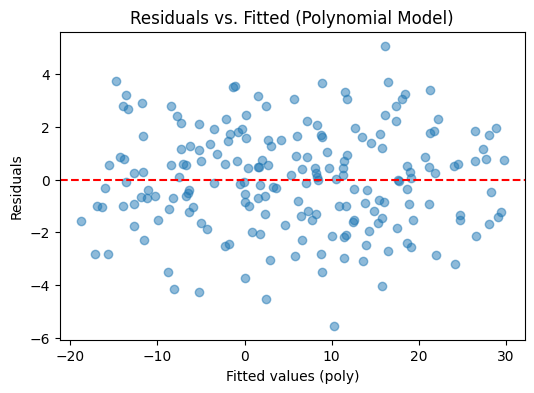

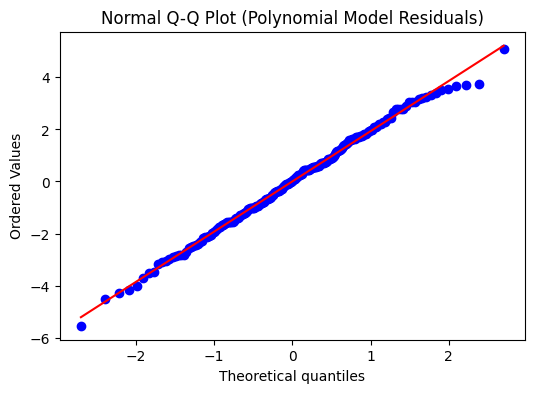

In [15]:
residuals_poly = model_poly_sm.resid
fitted_poly = model_poly_sm.fittedvalues

plt.figure(figsize=(6,4))
plt.scatter(fitted_poly, residuals_poly, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted values (poly)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted (Polynomial Model)")
plt.show()

plt.figure(figsize=(6,4))
probplot(residuals_poly, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot (Polynomial Model Residuals)")
plt.show()



**Interpretation**:
- If the polynomial model captures more structure, we may see less pattern in the residuals plot.
- Alternatively, if the true relationship was already linear, polynomial terms might just overfit or remain insignificant.



## 5. RBF Expansion

Polynomial feature expansion is a powerful tool to introduce **non-linearity** into a linear regression model, but it has several limitations:

- **Feature explosion**: As the polynomial degree increases, the number of new features grows **exponentially**, making models computationally expensive and prone to overfitting.
- **Global transformations**: Polynomial terms like $X^2, X^3$ affect the entire input space, meaning that small changes in $X$ have a large impact everywhere, which might not always be desirable.
- **Poor handling of local variations**: Polynomial functions are not ideal when the relationship between $X$ and $y$ has local variations or is non-smooth.

This is where **Radial Basis Function (RBF) expansion** can be useful.

---

### **What is RBF Expansion?**
RBF expansion **maps the original features into a higher-dimensional space** using functions that respond **locally** to the input values.

Instead of using polynomial transformations like:

$$
y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_1^2 + \beta_5 X_2^2 + \beta_6 X_3^2 + \beta_7 X_1X_2 + ...
$$

We use **random Fourier features** to approximate an RBF kernel, generating transformed variables like:

$$
\Phi(X) = \cos(WX) + \sin(WX)
$$

where $ W $ is a random weight matrix sampled from a Gaussian distribution.

#### **Why Use RBF Instead of Polynomial Expansion?**
- **Better for local variations**: Unlike polynomials, RBFs can capture **localized** structures in data.
- **Fixed feature size**: The number of transformed features is independent of the input size, making it computationally efficient.
- **Good for high-dimensional data**: Works well when the input space is **high-dimensional** because it avoids feature explosion.

---

### **Implementing RBF Expansion with Random Fourier Features**
We use `sklearn.kernel_approximation.RBFSampler` to generate **random Fourier features** that approximate the RBF kernel.


RBF-transformed shape: (200, 50)
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     146.9
Date:                Mon, 03 Feb 2025   Prob (F-statistic):          5.70e-105
Time:                        15:10:35   Log-Likelihood:                -396.22
No. Observations:                 200   AIC:                             894.4
Df Residuals:                     149   BIC:                             1063.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -43.48

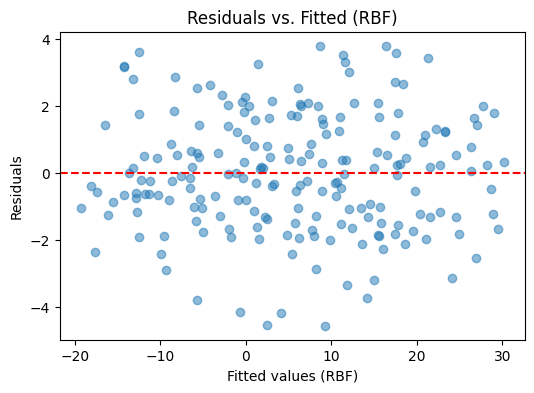

In [16]:
from sklearn.kernel_approximation import RBFSampler

rbf = RBFSampler(gamma=0.05, n_components=50, random_state=123)
X_rbf = rbf.fit_transform(df[['X1','X2','X3']])
print("RBF-transformed shape:", X_rbf.shape)

# We'll do OLS with statsmodels for brevity:
X_rbf_sm = sm.add_constant(X_rbf)
model_rbf_sm = sm.OLS(df['Y'], X_rbf_sm).fit()

print(model_rbf_sm.summary())

resid_rbf = model_rbf_sm.resid
fitted_rbf = model_rbf_sm.fittedvalues

plt.figure(figsize=(6,4))
plt.scatter(fitted_rbf, resid_rbf, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted values (RBF)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted (RBF)")
plt.show()



**Comments**:
- Each RBF feature is basically a sinusoidal basis function in random projection space.
- We could also attempt a manual approach: 
  $$
    \hat{\beta} = (X_{\mathrm{rbf}}^\top X_{\mathrm{rbf}})^{-1} X_{\mathrm{rbf}}^\top y
  $$
  if we want to replicate the normal equation style. 
- The dimensionality (50) can be large, so be mindful of potential numerical issues and overfitting.

---

## 6. Ridge Regression (Separate Section)

For complex expansions (like polynomial of high degree or many RBF components), **overfitting** can happen. 
Ridge regression adds an L2 penalty:
$$
  \min_{\beta} \;\; \| Y - X \beta \|^2 + \alpha \| \beta \|^2.
$$

### 6.1 Ridge Closed-form (Optional Manual)

Ridge also has a known closed-form:
$$
  \hat{\beta}_{\mathrm{ridge}} = (X^\top X + \alpha I)^{-1} X^\top Y.
$$

We'll show a manual solution, then compare to scikit-learn. We'll do it on the **polynomial features** for illustration.


In [17]:
# 6.1 Manual ridge on polynomial features
alpha_ridge = 10.0
I_p = np.eye(X_poly_mat.shape[1])  # dimension p x p, where p = number of poly features + 1 (intercept)

# Usually we do not regularize the intercept, so we might set I_p[0,0] = 0.
# Let's do that to avoid shrinking the intercept:
I_p[0,0] = 0.0

XTX_ridge = X_poly_mat.T @ X_poly_mat + alpha_ridge*I_p
XTX_ridge_inv = np.linalg.inv(XTX_ridge)
XTy_ridge = X_poly_mat.T @ y_vec
beta_hat_ridge_manual = XTX_ridge_inv @ XTy_ridge
beta_hat_ridge_manual = beta_hat_ridge_manual.flatten()

print("Manual Ridge (polynomial) shape:", beta_hat_ridge_manual.shape)
print("Manual Ridge Coeffs (first 10):", beta_hat_ridge_manual[:10], "...")


Manual Ridge (polynomial) shape: (10,)
Manual Ridge Coeffs (first 10): [ 5.05470297e+00  1.46665406e+00 -1.96169432e+00  5.23807338e-01
  3.67015344e-03  5.08497631e-03  2.41966108e-02  3.72075480e-03
  1.33022165e-02 -3.78535324e-03] ...


In [18]:
# 6.2 Compare with scikit-learn Ridge
from sklearn.linear_model import Ridge

ridge_sklearn = Ridge(alpha=alpha_ridge, fit_intercept=False) 
# "fit_intercept=False" because we already included the intercept column in X_poly_mat
# We will manually set the intercept to match the first column or we can remove intercept from X_poly_mat.

ridge_sklearn.fit(X_poly_mat, df['Y'])
beta_hat_ridge_sklearn = ridge_sklearn.coef_

print("scikit-learn Ridge Coeffs (first 10):", beta_hat_ridge_sklearn[:10])
print("\nDifference (manual - sklearn):", 
      (beta_hat_ridge_manual - beta_hat_ridge_sklearn)[:10])


scikit-learn Ridge Coeffs (first 10): [ 4.16565878  1.47332078 -1.96112324  0.52354299  0.03866316  0.0072884
  0.03295988  0.01222439  0.01172196  0.03223633]

Difference (manual - sklearn): [ 8.89044190e-01 -6.66671850e-03 -5.71081307e-04  2.64349167e-04
 -3.49930036e-02 -2.20341958e-03 -8.76326836e-03 -8.50363590e-03
  1.58025824e-03 -3.60216792e-02]



They should be nearly identical (tiny floating discrepancies may occur).

### 6.3 Residual analysis for Ridge


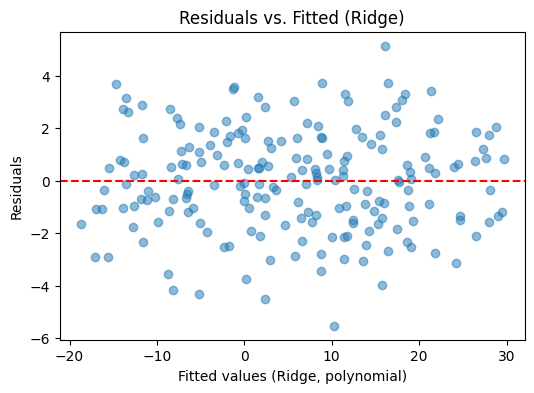

In [19]:
y_pred_ridge = X_poly_mat @ beta_hat_ridge_manual
resid_ridge = df['Y'] - y_pred_ridge

plt.figure(figsize=(6,4))
plt.scatter(y_pred_ridge, resid_ridge, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted values (Ridge, polynomial)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted (Ridge)")
plt.show()



**Remarks**:
- As alpha_ridge increases, the polynomial coefficients shrink more, typically reducing variance (but possibly increasing bias).
- We can further use cross-validation to select alpha automatically or do a hyperparameter grid.

---

## Final Comments

**In this TP**:
1. We generated **multivariate** synthetic data with known coefficients.
2. **Manually computed** the OLS solution and compared results with `statsmodels` OLS.
4. **Performed residual tests** (residual vs. fitted, Q-Q plots).
5. Introduced **Polynomial expansions** and **RBF expansions** 
6. Introduced **Ridge regression**.

This workflow demonstrates how to:
- Implement linear models using the **closed-form** normal equations.
- Expand the feature space to handle **non-linear** relationships.
- Use **regularization** (ridge) to mitigate overfitting in high-dimensional expansions.

*End of TP2*.
